<a href="https://colab.research.google.com/github/bwliv/columbia/blob/master/BadMovieNight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **"Bad Movie Night":** *Cult Movie Recommendations Using Personal Variance*
Anjani Prasad Atluri aa4462@columbia.edu GitHub: apalmk

Benjamin Livingston bwl2114@columbia.edu GitHub: bwliv

Karan Rao ksr2136@columbia.edu GitHub: raokaran

Chengyi Chen cc4506@columbia.edu GitHub: ccysysu



# Introduction

If you want to have a bad movie night, where do you look?

Maybe you Google “bad movies”. Maybe you ask your friends for recommendations. But your favorite streaming service or movie website isn’t going to go out of its way to recommend a bad movie to you.

But what exactly is a “bad movie”? After all, if you truly thought it was bad, you wouldn’t watch it or enjoy it. In reality, “bad movie” doesn’t always mean bad movie. Very often, it means a movie everyone else thinks is bad that a user sort of enjoys. This is akin to the concept of a “cult movie” - one that a user finds much more interesting than the general populace. 

That is our aim: to build a cult movie recommender that can fuel a cult movie lover’s “bad movie night”. 

This hearkens back to the biggest challenge of Netflix Prize models, which consistently struggled with these sorts of movies (in their case, specifically Napoleon Dynamite):
https://kottke.org/08/11/the-netflix-prize-and-the-case-of-the-napoleon-dynamite-problem

We take this to heart, and take little interest in recommending generally acclaimed movies or serving users that have mainstream tastes. We are aiming for the weird, the cheesy, the off-beat - the kind of movie you might throw on for a laugh when you have friends over. There’s definitely a market for it. On some nights, you’re more interested in going against the grain than watching a movie that got a 98% on Rotten Tomatoes. Our system is built to accomplish that.
We initially looked at the rating distributions of movies we felt were “culty” - The Room (2003), for example – and noticed that their ratings were close to average (2.0-3.0ish), but that they had more positive ratings than expected. They also had a large number of negative ratings. To frame this mathematically, their ratings had high variance. 

To test this hypothesis that high-variance movies were culty, we pulled up the top ten high-variance rating movies (among those with at least 100 ratings), and these were indeed movies with a polarizing, “culty” feel to them.

In [0]:
# set parameters

# set k for "top k movies recommended"
n_recommended = 10

# set minimum number of times movie should be rated to enter set
lowest_count = 100

# set latent dimensions for matrix factorization
uniform_rank = 5

In [0]:
#Insert Top 10 High Variance Movies Here in Notebook
from google.colab import drive
drive.mount('/content/drive')

# generate top n_recommended default recommendations

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/MovieLens190/ratings.csv', encoding = "ISO-8859-1")
movie_names = pd.read_csv('/content/drive/My Drive/MovieLens190/movies.csv', encoding = "ISO-8859-1")

df['count'] = df.groupby(['movieId'])['rating'].transform('count')
df = df[df['count']>=lowest_count]
df['means'] = df.groupby(['movieId'])['rating'].transform('mean')
df['var'] = df.groupby(['movieId'])['rating'].transform('var')
df['ppv']=df['rating']-df['means']

# get high variance movies
df2 = df[['movieId','rating']]
df3 = df2.groupby(['movieId']).var()
df3 = df3.nlargest(n_recommended,'rating')
high_var = pd.DataFrame(df3.index)

movie_list = pd.merge(high_var,movie_names,how='inner',left_on=['movieId'],right_on=['movieId'])[['title']]
movie_list


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title
0,Santa with Muscles (1996)
1,"Room, The (2003)"
2,Expelled: No Intelligence Allowed (2008)
3,Troll 2 (1990)
4,"""Great Performances"" Cats (1998)"
5,Grateful Dead (1995)
6,High School Musical 3: Senior Year (2008)
7,Adrenalin: Fear the Rush (1996)
8,Nobody Loves Me (Keiner liebt mich) (1994)
9,Vampire in Venice (Nosferatu a Venezia) (Nosfe...


With this in mind, will will proceed considering variance as a good measure of a movie's "cultiness".

Serendipity is definitely a goal of ours here, but it's a special kind of serendipity: we want something that is novel to the user, but probably wouldn't be recommended by any sort of classic recommender system. We want recommendations that make the user raise their eyebrows, even if they’re not the best movies the user has ever seen. We're going for high-variance 3.5's, rather than 4s or 5s. We want the movie this user thinks is a 3.5-5 that most other people think is a 1-2.5, if it exists - perhaps a user’s “favorite bad movie”, if you will. Since these movies are polarizing, we’re willing to sacrifice overall accuracy for a few spot-on recommendations. We're not going for global success, we're just trying to help them discover one or two cult classic-style movies a normal recommender would be too "afraid" to show them in fear of poor overall KPIs.

Personal Variance (PV) and Personal Positive Variance (PPV) are heuristics we defined to show how the user’s rating of a movie differed from the mean. PV is simply the user’s rating minus the mean overall rating for that movie across all users. The PPV sets the resulting negative values to 0, and it was developed based on the theory that the low ratings users have in common say less about their movie loves than the high ratings they have in common. We called it “variance” because it mirrors a movie’s overall ratings variance at a more individual level (and because we considered raising it to a hyperparameter exponent originally).

#Business Concerns

Our goal is to serve culty users in general. Our model certainly will not be ideal for users that will be offended by more risky recommendations – children, people who are offended by gory movies, etc. – so a business implementation would need to be cautious. This is the case with any recommender system, but certainly the case for one that makes more extreme recommendations such as this.

We must acknowledge that big misses will be part of this recommender system. We will accept the risk that we will occasionally serve a movie that the user really hates. While RMSE would harshly penalize such a recommendation, we give it little thought. Our goal is to serve recommendations and have the user see one that surprises them and catches their interests, not to go 10-for-10.

Would this work as a comprehensive primary recommender system? No,  probably not,because it will miss more than most recommenders and suffers from coverage issues. But it could have success as an auxiliary recommender within a streaming service, perhaps an additional carousel on the front page of Netflix served only to some users and named appropriately to encapsulate what it’s doing.




In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install scikit-surprise

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# How Recommendations Are Served

We will proceed with a standard of suggesting 10 movies for each user, which will remain consistent for every recommender system we implement here. Whatever a user’s 10 highest-predicted ratings or PPVs are (this will depend on the system), those will be the movies we use for our evaluation.

We will then consider the holistic performance of these 10 recommendations per user across all users, viewing these recommendations as a single set of user-movie recommendations. We will judge them based on a few factors – recall (how many user-movie pairs in the test set – true positives – did we correctly predict?), the average user rating among the true positives (how much did the users like these movies that we correctly predicted they would watch?), and the average PV among those true positives (how much more did users like these movies than the average user does?).

We will implement a number of models to accomplish this:
1.       A matrix factorization model trained on integer user-movie PPV data*
2.       A matrix factorization model trained on floating point user-movie PPV data
3.       A matrix factorization model trained on integer user-movie PV data*
4.       A matrix factorization model trained on floating point user-movie PV data
5.       A matrix factorization model trained on raw user ratings
6.       An item-item system trained on floating point PPVs
7.       An item-item system trained on floating point PVs
8.       An item-item system trained on floating point ratings
9.       A system that simply recommends the top 10 high-variance movies of all time to every user uniformly

*During testing, it was discovered that using integer PV/PPV values occasionally yielded better performance in matrix factorization than using floating point values, so these models were maintained for experimentation.

1-5 are model-based, 6-8 are memory based, and 9 is a dummy baseline.

We will compute matrix factorization using alternating least squares and item-item using cosine-similarity scores to determine k-nearest neighbors.

We will run all nine of these, and judge the quality of the model based on the aforementioned true positives, average user rating among the true positives, and average personal variance among the true positives.

Our baselines will be #5, #8, and #9 on this list. We will examine how using raw ratings compares to using PVs/PPVs (and critically evaluate why it performs the way it does), and we will also examine how simply suggesting the “top 10 culty movies” (by our mathematical definition) compares to serving a more personalized list of culty movies.


#Subsetting

We are aiming to build a recommender system for “culty” users, and for that reason we will be subsetting in a way that takes the top n percentile culty users (we will proceed with n = 10 as our default value - even a subset of this size left our algorithm needing an hour to run, whereas for n = 1 it ran in less than mere minutes, for n = 7 it ran in 23 minutes, and for n = 25, we could not run the model in a reasonable time window ... and n = 7 and n = 10 were the only ones that yielded time-efficient, steady results). 

We will do this subsetting by user by examining a user’s average PPV. We acknowledge that this may also result in our set of “culty” users containing serially positive users, but it will be difficult to define high-variance rating users in any way that does not integrate serially positive or negative users.

We will also be removing any movie that has fewer than 100 ratings - the logic here is that movies with very few ratings will inherently be prone to higher variances that are a product of small sample size more than anything. Thus, removing these movies from the data set becomes necessary in order to ensure well-formulated predictions.

Ideally, we would not perform any additional subsetting based on movies beyond this, because personalizing a cult movie list requires catering to a user’s most extreme tastes, and this is difficult to achieve across a wide swath of users if we are removing a significant number of movies from the data set. Nearly every movie has fervent devotees, so removing even slightly popular movies from the set could easily alienate users and limit our ability to serve them.

However, this is infeasible, as it would create an input size that Python could not handle (we certainly tried to make it work). For this reason, we will subset movies in the most logical way for our model - by taking the top n percentile highest-variance (i.e. “cultiest”) movies among those with at least 100 ratings (our running time benchmarks above factored in this subsetting as well). This will give us the best chance of capturing extreme tastes and properly serving recommendations simultaneously.

Inherently, the coverage of our approach will suffer. This will not work as a general-purpose recommender because it is designed to serve culty users (and thus will have poor user coverage) culty movies (and thus it will have poor item coverage). However, this is by design- in no way are we trying to build something that works across all users and items (as we are explicitly focusing on culty users), so coverage is a less meaningful metric for our purposes.


In [0]:
#Reading and subsetting the data
import math as m
from numpy.random import choice
import pandas as pd
from google.colab import drive
from collections import defaultdict

df = pd.read_csv('/content/drive/My Drive/MovieLens190/ratings.csv', encoding = "ISO-8859-1")
lowest_count=100
prop_subset=0.1
df['means'] = df.groupby(['movieId'])['rating'].transform('mean')
df['var'] = df.groupby(['movieId'])['rating'].transform('var')
df['ppv']=df['rating']-df['means']
df['count'] = df.groupby(['movieId'])['rating'].transform('count')
df=df.loc[df['count'] >=lowest_count]

# set up subsetting users by ppv
culty_users = df[df['ppv']>0]
cu1=culty_users.groupby('userId', as_index=False)['ppv'].mean()
amount = m.floor(cu1.shape[0]*prop_subset)
culty_userss = cu1.nlargest(amount,'ppv')
cu2=culty_userss['userId'].tolist()
final_df=df
final_df = final_df[final_df['userId'].isin(cu2)]

# set up subsetting movies by variance
culty = final_df.groupby('movieId', as_index=False)['var'].mean()
amount = m.floor(len(culty) * prop_subset)
culty_movies = culty.nlargest(amount,['var'])
cm2 = culty_movies['movieId'].tolist()
final_df = final_df[final_df['movieId'].isin(cm2)]


# Cross-Validation Setup

We will be conducting cross-evaluation using a random train-test split, developing our recommendations based on the user-movie pairs in the training data and then evaluating them based on the user-movie pairs in the test data.

The reason we are doing this randomly is that if the data is split on the time stamp, the training set is much more likely to have different users and movies from the test set, and because of this the item-item based collaborative filtering is not able to predict the scores of a lot of new items in the test set (cold start problem). We experienced this cold start problem extremely frequently during our experimentation, although those results are omitted from this main code writeup for brevity (although a summary is available in the appendix).

This is a particularly large problem in our application because of the problem of movie removal that we referenced before – removing movies from the training set (something that is more likely if you train-test split by time stamp) is particularly problematic for our application. Thus, we will proceed with a completely random train-test split.
 


In [0]:
from sklearn.model_selection import train_test_split
import copy

min_ppv=final_df['ppv'].min()
max_ppv=final_df['ppv'].max()

train1, test1 = train_test_split(final_df, test_size=0.2)

#Changing the dataframe into userId, movieId, rating (PPV) format to send it as input to Surprise libraries data structure
fin=copy.deepcopy(final_df[['userId', 'movieId', 'ppv','rating']])
train=copy.deepcopy(train1[['userId', 'movieId', 'ppv','rating']])
test_set=copy.deepcopy(test1[['userId', 'movieId', 'ppv','rating']])
train_set_ppv= train[train['ppv'] >= 0]
train_set_pv=train

In [0]:
# helper function for spark data frames

from pyspark.sql.functions import explode

def movie_explode(recs):
  df1 = recs.withColumn("recommendations", explode("recommendations"))
  df2 = df1.toPandas()
  df2['movieId'] = df2.apply(lambda row: row.recommendations[0],axis=1)
  df2['rating'] = df2.apply(lambda row: row.recommendations[1],axis=1)
  df2 = df2.drop('recommendations',axis=1)
  return df2

In [0]:
# introduce baseline of recommending top n_recommend high variance movies - no NOT need to be from test set

evaluate_default = pd.merge(test_set,high_var,how='inner',left_on=['movieId'],right_on=['movieId'])
high_var_recall = evaluate_default.shape[0] / test_set.shape[0]
high_var_rating = evaluate_default['rating'].mean()
high_var_ppv = evaluate_default['ppv'].mean()
high_var_default = pd.DataFrame([high_var_recall,high_var_rating,high_var_ppv]).transpose()
high_var_default.columns = ['Recall','Mean rating','Mean PPV']

#How Hyperparameters Will Be Tuned

We will consider a handful of hyperparameter levels for our two hyperparameters: number of latent dimensions for matrix factorization (5, 10, 20, 50, and 100), and neighborhood size for K-nearest neighbors (5, 15, 30, 50, 100). Each of these will be represented as a point on a line in our final line graphs, which will help us evaluate our various approaches using our metrics (we are more concerned with a model's best performance compared to other models' best performance than its performance across hyperparameters, and our graphing style will reflect this). 


In [0]:
from pyspark.sql import SparkSession as spark_session
spark_session.createDataFrame
spark.conf.set("spark.sql.execution.arrow.enabled","true")
spark_train_pv = spark.createDataFrame(train_set_pv)
spark_train_ppv = spark.createDataFrame(train_set_ppv)
spark_test = spark.createDataFrame(test_set)

##**Matrix Factorization Models (ALS)**

We will start by training and examining our matrix factorization models

In [0]:
ppvintRows = []
ppvfloatRows = []
pvintRows = []
pvfloatRows = []
baselineRows = []

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

spark_train_pv = spark.createDataFrame(train_set_pv)
spark_train_pv_int = spark.createDataFrame(train_set_pv)

spark_train_ppv = spark.createDataFrame(train_set_ppv)
spark_train_ppv_int = spark.createDataFrame(train_set_ppv)

spark_train_ppv = spark_train_ppv.withColumn("userId", spark_train_ppv["userId"].cast(IntegerType()))
spark_train_ppv = spark_train_ppv.withColumn("movieId", spark_train_ppv["movieId"].cast(IntegerType()))
spark_train_ppv = spark_train_ppv.withColumn("ppv", spark_train_ppv["ppv"].cast(DoubleType()))

spark_train_ppv_int = spark_train_ppv_int.withColumn("userId", spark_train_ppv_int["userId"].cast(IntegerType()))
spark_train_ppv_int = spark_train_ppv_int.withColumn("movieId", spark_train_ppv_int["movieId"].cast(IntegerType()))
spark_train_ppv_int = spark_train_ppv_int.withColumn("ppv", spark_train_ppv_int["ppv"].cast(IntegerType()))

spark_train_pv = spark_train_pv.withColumn("userId", spark_train_pv["userId"].cast(IntegerType()))
spark_train_pv = spark_train_pv.withColumn("movieId", spark_train_pv["movieId"].cast(IntegerType()))
spark_train_pv = spark_train_pv.withColumn("ppv", spark_train_pv["ppv"].cast(DoubleType()))

spark_train_pv_int = spark_train_pv_int.withColumn("userId", spark_train_pv_int["userId"].cast(IntegerType()))
spark_train_pv_int = spark_train_pv_int.withColumn("movieId", spark_train_pv_int["movieId"].cast(IntegerType()))
spark_train_pv_int = spark_train_pv_int.withColumn("ppv", spark_train_pv_int["ppv"].cast(IntegerType()))


In [0]:
ranks = [5, 10, 20, 50, 100]


def evaluator(userRecs):
  topten = movie_explode(userRecs)
  evaluation = pd.merge(test_set,topten,how='inner',left_on=['movieId','userId'],right_on=['movieId','userId'])
  return evaluation

def evaluate_return(userRecs):
  evalu = evaluator(userRecs)
  #return rank (for convenience - removed), recall, mean rating, mean ppv of predictions
  return [evalu.shape[0]/len(test_set), evalu['rating_x'].mean(), evalu['ppv'].mean()]

In [0]:
#Implement model with floating point PPV (Personal Positive Variance) transformation
# Build the recommendation model using ALS on the training data
for r in ranks:
  uniform_rank = r
  als = ALS(maxIter=5, regParam=0.01, rank = uniform_rank, userCol="userId", itemCol="movieId", ratingCol="ppv",
            coldStartStrategy="drop")
  model = als.fit(spark_train_ppv)

  # Generate top 10 movie recommendations for each user
  ppvfloatRecs = model.recommendForAllUsers(n_recommended)



  #Implement model with integer PPV (Personal Positive Variance) transformation


  # Build the recommendation model using ALS on the training data
  als = ALS(maxIter=5, regParam=0.01, rank = uniform_rank, userCol="userId", itemCol="movieId", ratingCol="ppv",
            coldStartStrategy="drop")
  model = als.fit(spark_train_ppv_int)

  # Generate top 10 movie recommendations for each user
  ppvintRecs = model.recommendForAllUsers(n_recommended)


  # Implement model with floating point PV (Personal Variance - can be negative!) transformation 

  # NOTE that this data set is different, and thus train-test split will be different for our non-negative personal variance transformation
  als = ALS(maxIter=5, regParam=0.01, rank = uniform_rank, userCol="userId", itemCol="movieId", ratingCol="ppv",
            coldStartStrategy="drop")
  model = als.fit(spark_train_pv)
  # Generate top 10 movie recommendations for each user
  pvfloatRecs = model.recommendForAllUsers(n_recommended)



  # Implement model with integer PV (Personal Variance - can be negative!) transformation 
  als = ALS(maxIter=5, regParam=0.01, rank = uniform_rank, userCol="userId", itemCol="movieId", ratingCol="ppv",
            coldStartStrategy="drop")
  model = als.fit(spark_train_pv_int)

  # Generate top 10 movie recommendations for each user
  pvintRecs = model.recommendForAllUsers(n_recommended)


  # Implement model with baseline using rating to judge

  # build matrix factorization model
  als = ALS(maxIter=5, regParam=0.01, rank = uniform_rank, userCol="userId", itemCol="movieId", ratingCol="rating",
            coldStartStrategy="drop")
  model = als.fit(spark_train_pv)

  # Generate top n_recommend movie recommendations for each user
  baselineRecs = model.recommendForAllUsers(n_recommended)

  #evaluate using metrics 

  row = evaluate_return(ppvintRecs)
  ppvintRows.append(row)

  row = evaluate_return(ppvfloatRecs)
  ppvfloatRows.append(row)

  row = evaluate_return(pvintRecs)
  pvintRows.append(row)

  row = evaluate_return(pvfloatRecs)
  pvfloatRows.append(row)

  row = evaluate_return(baselineRecs)
  baselineRows.append(row)

spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: StructType(List(StructField(movieId,IntegerType,true),StructField(rating,FloatType,true)))
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [0]:
ppvFloatALS = pd.DataFrame.from_records(ppvfloatRows, columns = ['Recall', 'Mean rating', 'Mean PPV'])
ppvIntALS = pd.DataFrame.from_records(ppvintRows, columns = ['Recall', 'Mean rating', 'Mean PPV'])
pvFloatALS = pd.DataFrame.from_records(pvfloatRows, columns = ['Recall', 'Mean rating', 'Mean PPV'])
pvIntALS = pd.DataFrame.from_records(pvintRows, columns = ['Recall', 'Mean rating', 'Mean PPV'])
baselineALS = pd.DataFrame.from_records(baselineRows, columns = ['Recall', 'Mean rating', 'Mean PPV'])

## **Item-Item based recommendation**

*For the cosine similarity calculation, the surprise library imputes the NA values to zeros, which we were told was okay in class.*

In [0]:
#reshaping data as per the requirements of the package
fin=copy.deepcopy(fin[['userId', 'movieId', 'ppv']])
ratings_train=copy.deepcopy(train[['userId', 'movieId','rating']])
train=copy.deepcopy(train[['userId', 'movieId', 'ppv']])
test = copy.deepcopy(test_set[['userId', 'movieId', 'ppv']])
train_set_ppv= train_set_ppv[['userId', 'movieId', 'ppv']]
train_set_pv=train

In [0]:
#Finding cosine similarity matrix for PPVs based model

import pandas as pd
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

# The reader of dataframe has to know the minimum and maximum values that can be taken by the ppv column
reader = Reader(rating_scale=(min_ppv, max_ppv))

data=Dataset.load_from_df(fin,reader)

ppv_train_data = Dataset.load_from_df(train_set_ppv, reader)

ppv_trainset = data.construct_trainset(ppv_train_data.raw_ratings)

#Taking cosine similarity, doing item based filtering
similarity_options = {'name': 'cosine',
               'user_based': False 
               }

#>>Note: For the distance calculation, the NAs are getting impuned to 0s, when we made a custom similarity calculation for vectors, it was taking too long to run, impuning the NAs
#to zeros is making the libraries do vector dot products, making the model run faster. Since there will not be a lot of difference after impuning to 0s.

#Parameter K is the no of neighbours being considered, min_k is incase we dont have k neighbours who many minimum should we consider
Knnobject = KNNBasic(k=5, min_k=5, sim_options=similarity_options, verbose=True)

#This will learn the simialrity matrix and get the K nearest neighbours for each user
Knnobject.fit(ppv_trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [0]:
#Finding cosine similarity matrix for PVs based model

pv_train_data = Dataset.load_from_df(train_set_pv, reader)
pv_trainset = data.construct_trainset(pv_train_data.raw_ratings)

Knnobject1 = KNNBasic(k=10, min_k=5, sim_options=similarity_options, verbose=True)

Knnobject1.fit(pv_trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [0]:
#Doing it for baseline of using ratings instead of PPVs or PVs

ratings_train_data = Dataset.load_from_df(ratings_train, reader)
ratings_trainset = data.construct_trainset(ratings_train_data.raw_ratings)

Knnobject2 = KNNBasic(k=10, min_k=5, sim_options=similarity_options, verbose=True)

Knnobject2.fit(ratings_trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [0]:
#This module will calculate the estimated ratings for all the users in the test set v/s all the movies in the test set
def manual_predict_func(modelobject):
  dat1=[]

  users = test['userId'].unique()
  movies=test['movieId'].unique()

  for u in users:
    for m in movies:
      #Predict function will output the estimated scores of the user item pair based on the similarities the model learnt from the training set
      pre=modelobject.predict(u,m)
      if pre.details['was_impossible']:
        #cold start condition giving -ve rating so that it won't be recommended easily
        dat1.append([u,m,-10])
      else:
        dat1.append([u,m,pre.est])

  dffi = pd.DataFrame(dat1, columns=['userId', 'movieId', 'rating'])
  return dffi

In [0]:
#Getting predicitions for PPV
predictions1=manual_predict_func(Knnobject)

#Getting predicitons for PVs
predictions2=manual_predict_func(Knnobject1)

#Getting predicitons for raw ratings
predictions3=manual_predict_func(Knnobject2)

In [0]:
#Getting top 10 recomendations for each users using PPV
grouped = predictions1.groupby('userId')

new_df = pd.DataFrame([], columns = predictions1.columns)

for key, values in grouped:

    new_df = pd.concat([new_df, grouped.get_group(key).sort_values('rating', ascending=False)[:10]], 0)

#Getting top 10 reccomendations for each users using PV
grouped1 = predictions2.groupby('userId')

new_df1 = pd.DataFrame([], columns = predictions2.columns)

for key, values in grouped1:

    new_df1 = pd.concat([new_df1, grouped1.get_group(key).sort_values('rating', ascending=False)[:10]], 0)

#Getting top 10 reccomendations for each users raw reccomendations
grouped2 = predictions3.groupby('userId')

new_df2 = pd.DataFrame([], columns = predictions3.columns)

for key, values in grouped2:

    new_df2 = pd.concat([new_df2, grouped2.get_group(key).sort_values('rating', ascending=False)[:10]], 0)


In [0]:
#reusable function version of the above code
def getTop10(dff):
  grouped = dff.groupby('userId')

  new_df2 = pd.DataFrame([], columns = dff.columns)

  for key, values in grouped:

    new_df2 = pd.concat([new_df2, grouped.get_group(key).sort_values('rating', ascending=False)[:10]], 0)

  return new_df2

In [0]:
#Evaluation Functions

def evaluator1(userRecs):
  evaluation = pd.merge(test_set,userRecs,how='inner',left_on=['movieId','userId'],right_on=['movieId','userId'])
  return evaluation

def evaluate1(userRecs):
  eval = evaluator1(userRecs)

In [0]:
#Evaluating our models
evaluate1(new_df)
evaluate1(new_df1)
evaluate1(new_df2)

In [0]:
#Reusable version of evaluations that returns mean ppv, mean ratings, recall as a list 
def re_use_evaluate(userRecs):
  eval = evaluator1(userRecs)
  return [eval['ppv'].mean(),eval['rating_x'].mean(), (eval.shape[0]/len(test_set))]

**Checking for different values of Hyperparameters**
<br>
We opted not to looping through one function for the various neighborhood sizes, as the previous values of the Knnobject are would get used from cache instead of new values, thus producing the old results.

In [0]:
#For neighbourhood size of 5 for PV based model

train_data5pv= Dataset.load_from_df(train_set_pv,reader)
trainset5pv= data.construct_trainset(train_data5pv.raw_ratings)
Knnobject5pv= KNNBasic(k=5, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject5pv.fit(trainset5pv)
pred5pv=manual_predict_func(Knnobject5pv)
df5pv=getTop10(pred5pv)
l5pv=re_use_evaluate(df5pv)

#For neighbourhood size of 5 for PPV based model

train_data5ppv= Dataset.load_from_df(train_set_ppv,reader)
trainset5ppv= data.construct_trainset(train_data5ppv.raw_ratings)
Knnobject5ppv= KNNBasic(k=5, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject5ppv.fit(trainset5ppv)
pred5ppv=manual_predict_func(Knnobject5ppv)
df5ppv=getTop10(pred5ppv)
l5ppv=re_use_evaluate(df5ppv)

#For neighbourhood size of 5 for ratings based baseline model

train_data5r= Dataset.load_from_df(ratings_train,reader)
trainset5r= data.construct_trainset(train_data5r.raw_ratings)
Knnobject5r= KNNBasic(k=5, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject5r.fit(trainset5r)
pred5r=manual_predict_func(Knnobject5r)
df5r=getTop10(pred5r)
l5r=re_use_evaluate(df5r)

#For neighbourhood size of 15 for PV based model

train_data15pv= Dataset.load_from_df(train_set_pv,reader)
trainset15pv= data.construct_trainset(train_data15pv.raw_ratings)
Knnobject15pv= KNNBasic(k=15, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject15pv.fit(trainset15pv)
pred15pv=manual_predict_func(Knnobject15pv)
df15pv=getTop10(pred15pv)
l15pv=re_use_evaluate(df15pv)

#For neighbourhood size of 15 for PPV based model

train_data15ppv= Dataset.load_from_df(train_set_ppv,reader)
trainset15ppv= data.construct_trainset(train_data15ppv.raw_ratings)
Knnobject15ppv= KNNBasic(k=15, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject15ppv.fit(trainset15ppv)
pred15ppv=manual_predict_func(Knnobject15ppv)
df15ppv=getTop10(pred15ppv)
l15ppv=re_use_evaluate(df15ppv)

#For neighbourhood size of 15 for ratings based baseline model

train_data15r= Dataset.load_from_df(ratings_train,reader)
trainset15r= data.construct_trainset(train_data15r.raw_ratings)
Knnobject15r= KNNBasic(k=15, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject15r.fit(trainset15r)
pred15r=manual_predict_func(Knnobject15r)
df15r=getTop10(pred15r)
l15r=re_use_evaluate(df15r)

#For neighbourhood size of 30 for PV based model

train_data30pv= Dataset.load_from_df(train_set_pv,reader)
trainset30pv= data.construct_trainset(train_data30pv.raw_ratings)
Knnobject30pv= KNNBasic(k=30, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject30pv.fit(trainset30pv)
pred30pv=manual_predict_func(Knnobject30pv)
df30pv=getTop10(pred30pv)
l30pv=re_use_evaluate(df30pv)

#For neighbourhood size of 30 for PPV based model

train_data30ppv= Dataset.load_from_df(train_set_ppv,reader)
trainset30ppv= data.construct_trainset(train_data30ppv.raw_ratings)
Knnobject30ppv= KNNBasic(k=30, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject30ppv.fit(trainset30ppv)
pred30ppv=manual_predict_func(Knnobject30ppv)
df30ppv=getTop10(pred30ppv)
l30ppv=re_use_evaluate(df30ppv)

#For neighbourhood size of 30 for ratings based baseline model

train_data30r= Dataset.load_from_df(ratings_train,reader)
trainset30r= data.construct_trainset(train_data30r.raw_ratings)
Knnobject30r= KNNBasic(k=30, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject30r.fit(trainset30r)
pred30r=manual_predict_func(Knnobject30r)
df30r=getTop10(pred30r)
l30r=re_use_evaluate(df30r)

#For neighbourhood size of 50 for PV based model

train_data50pv= Dataset.load_from_df(train_set_pv,reader)
trainset50pv= data.construct_trainset(train_data50pv.raw_ratings)
Knnobject50pv= KNNBasic(k=50, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject50pv.fit(trainset50pv)
pred50pv=manual_predict_func(Knnobject50pv)
df50pv=getTop10(pred50pv)
l50pv=re_use_evaluate(df50pv)

#For neighbourhood size of 50 for PPV based model

train_data50ppv= Dataset.load_from_df(train_set_ppv,reader)
trainset50ppv= data.construct_trainset(train_data50ppv.raw_ratings)
Knnobject50ppv= KNNBasic(k=50, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject50ppv.fit(trainset50ppv)
pred50ppv=manual_predict_func(Knnobject50ppv)
df50ppv=getTop10(pred50ppv)
l50ppv=re_use_evaluate(df50ppv)

#For neighbourhood size of 50 for ratings based baseline model

train_data50r= Dataset.load_from_df(ratings_train,reader)
trainset50r= data.construct_trainset(train_data50r.raw_ratings)
Knnobject50r= KNNBasic(k=50, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject50r.fit(trainset50r)
pred50r=manual_predict_func(Knnobject50r)
df50r=getTop10(pred50r)
l50r=re_use_evaluate(df50r)

#For neighbourhood size of 100 for PV based model

train_data100pv= Dataset.load_from_df(train_set_pv,reader)
trainset100pv= data.construct_trainset(train_data100pv.raw_ratings)
Knnobject100pv= KNNBasic(k=100, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject100pv.fit(trainset100pv)
pred100pv=manual_predict_func(Knnobject100pv)
df100pv=getTop10(pred100pv)
l100pv=re_use_evaluate(df100pv)

#For neighbourhood size of 100 for PPV based model

train_data100ppv= Dataset.load_from_df(train_set_ppv,reader)
trainset100ppv= data.construct_trainset(train_data100ppv.raw_ratings)
Knnobject100ppv= KNNBasic(k=100, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject100ppv.fit(trainset100ppv)
pred100ppv=manual_predict_func(Knnobject100ppv)
df100ppv=getTop10(pred100ppv)
l100ppv=re_use_evaluate(df100ppv)

#For neighbourhood size of 100 for ratings based baseline model

train_data100r= Dataset.load_from_df(ratings_train,reader)
trainset100r= data.construct_trainset(train_data100r.raw_ratings)
Knnobject100r= KNNBasic(k=100, min_k=5, sim_options=similarity_options, verbose=True)
Knnobject100r.fit(trainset100r)
pred100r=manual_predict_func(Knnobject100r)
df100r=getTop10(pred100r)
l100r=re_use_evaluate(df100r)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [0]:
#Saving these values as a dataframes
import pandas as pd
lppv=[]
lppv.append(l5ppv)
lppv.append(l15ppv)
lppv.append(l30ppv)
lppv.append(l50ppv)
lppv.append(l100ppv)

ppv_itemitem=pd.DataFrame(lppv,columns=['Mean PPV','Mean rating','Recall'])

lpv=[]
lpv.append(l5pv)
lpv.append(l15pv)
lpv.append(l30pv)
lpv.append(l50pv)
lpv.append(l100pv)

pv_itemitem=pd.DataFrame(lpv,columns=['Mean PPV','Mean rating','Recall'])

lr=[]
lr.append(l5r)
lr.append(l15r)
lr.append(l30r)
lr.append(l50r)
lr.append(l100r)

ratings_itemitem=pd.DataFrame(lr,columns=['Mean PPV','Mean rating','Recall'])

#Evaluating Recommendations

In order to easily evaluate all of our systems in parallel across all recommender types (model-based, memory-based, and baseline high-variance recommendations) with minimal ambiguity, we will be plotting the metrics for all of them together on single graphs. Rather than representing hyperparameter levels on axes, we will represent metric levels (recall, mean user rating of movies service, and mean PPV of movies served) on the axes. 

*We were told in class that making adjustments to our plotting and metric style to fit our means was acceptable, and we have kept that in mind here. That being the case, we have taken some liberty with the representation of our results in an effort to allow them to be easy-to-understand for the reader, and properly evaluate our model's performance in regards to our goals.*

Each system will receive its own line (or a point in the case of our hyperparameter-free high-variance movies baseline), with each point corresponding to a tested hyperparameter level. There are more complex graphing techniques available, but we are aiming for simplicity. 

On our graphs, the simplest way to evaluate the success of a model will be to ask this: how close is the point to the upper right-hand corner? If one of our systems gets close to the right-hand corner in a graph, that is a sign that it is succeeding based on our metrics.

We will place the highest priority on PPV, which is our primary measurement: how a user likes a movie compared to the pack. We will care next most about recall, which gives us an idea of how well we are predicting users' tastes. We will place the least emphasis on straight ratings, because while we certainly don't want to serve users movies they hate, we are less concerned with giving them movies they rate a 5 than giving them movies they like more than most other people do.

In [0]:
import matplotlib.pyplot as plt
als = []
als.append(baselineALS)
als.append(ppvFloatALS)
als.append(ppvIntALS)
als.append(pvFloatALS)
als.append(pvIntALS)
als.append(high_var_default)
als.append(ppv_itemitem)
als.append(pv_itemitem)
als.append(ratings_itemitem)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set3')
l = ['baselineALS','ppvFloatALS','ppvIntALS','pvFloatALS','pvIntALS','high_var_def','ppv_itemitem','pv_itemitem','ratings_itemitem']

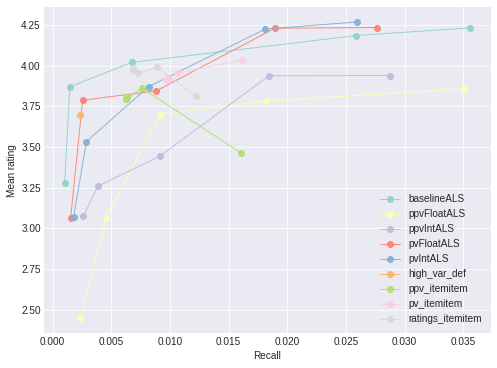

In [0]:
##Plot Recall VS Mean rating
num = -1
fig=plt.figure(figsize=(8, 6))
for i in als:
    num+=1
    plt.plot(i['Recall'], i['Mean rating'], marker='o', color=palette(num), linewidth=1, alpha=0.9,label = l[num])
    plt.legend(loc=2, ncol=2)
plt.xlabel("Recall")

plt.ylabel("Mean rating")
leg = plt.legend( loc = 'lower right')

We begin by looking at each system's peformance based on recall and the mean rating of the movies suggested.

Clearly, matrix factorization trained on raw ratings rules the day here, but other forms of matrix factorization trained on PVs and PPVs are not far behind in terms of both recall and mean rating, which we will keep in mind as we move forward. We also note that all improve massively with proper tuning.

Every iteration of item-item lags in recall for all tested neighborhood sizes and none excels in terms of mean rating, and the baseline of suggesting the top ten high variance movies (the single orange point) doesn't fare much better.

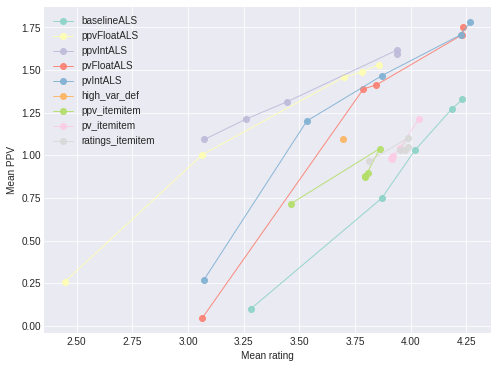

In [0]:
##Plot Mean rating VS Mean PPV
num = -1
fig=plt.figure(figsize=(8, 6))
for i in als:
    num+=1
    plt.plot(i['Mean rating'], i['Mean PPV'], marker='o', color=palette(num), linewidth=1, alpha=0.9,label = l[num])
    plt.legend(loc=2, ncol=2)
plt.xlabel("Mean rating")
plt.ylabel("Mean PPV")
plt.legend(loc = 'best')

Here, the x-axis represents how much users like these movies, and the y-axis represents how much more the users like these movies than the average user.

Of course, there is a strong positive correlation, and we see that the impact of hyperparameter tuning ranges from minimal to massive.

There is no question here that personal variance performs best in optimizing recommendations for movies the user will like *and* like much more than everyone else likes them. Item-item and the top ten high-variance movies again lag, and the personal positive variance models perform well, but not quite as well as personal variance.

We also note that matrix factorization trained on ratings doesn't yield high user ratings all that much better than matrix factorization performed with personal variance. Combine that with the fact that personal variance yields a much higher PPV value (i.e. recommendations that the user likes even more compared to the crowd), and we can argue that the personal variance model is the best here.

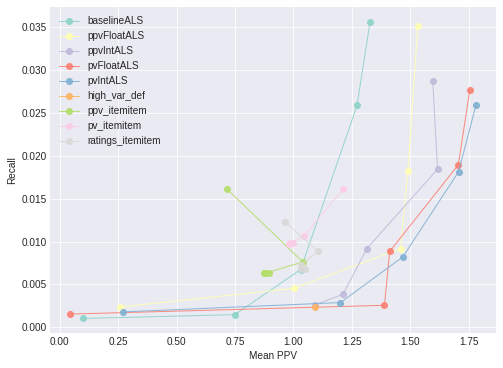

In [0]:
##Plot Mean PPV VS Recall
num = -1
fig=plt.figure(figsize=(8, 6))
for i in als:
    num+=1
    plt.plot(i['Mean PPV'], i['Recall'], marker='o', color=palette(num), linewidth=1, alpha=0.9,label = l[num])
    plt.legend(loc=2, ncol=2)
plt.xlabel("Mean PPV")
plt.ylabel("Recall")
plt.legend(loc = 'best')

In our final graph, we compare PPV and recall, asking how much more our users liked their recommendation than the average user would have, and seeing how accurate our predictions of what users would watch were.

This graph is somewhat less conclusive than the prior two graphs, but it's again clear that all of the matrix factorization models excel again (although the winner between the five of them isn't clear).

It seems that we have zeroed in on a matrix factorization model trained on personal variance, and we again see a strong (upper right-hand corner) performance here.

# Conclusions

From these results, we can clearly see that matrix factorization using raw ratings is the best way to make high-rating recommendations. However, we note that this runs counter to our goal, which was never to simply serve the highest-recommended movies. It's no surprise that the best overall predictions came by using raw rating, but we want to place special focus on predictors that serve high PPV movies and excel in recall. Again, our goal is not to serve the best movies, but make specialized recommendations that the user is apt to enjoy much more than the rest of the pack. 

Overall, it seems clear that matrix factorization won a decisive bout over item-item and our high-variance movie baseline, and within the matrix factorization models, the one trained on positive variance best fit our goals. 

(We also note that a similar (although somewhat more convoluted) pattern was evident with our smaller n = 7 (a.k.a. 7% or .07) subset, the graphs for which are included in our appendix. One common trend worth noting among all the models was that the performance slightly decreased across all metrics with an increased subset size. For an n = 1 (a.k.a. 1% or .01) subset, our metrics- and thus plot- were so all-over-the-place and convoluted that they were of no use.)

In short, we have a very simple, but profound result. We found that not only can we predict what movies a user will enjoy more than the pack, but we can do so without making massive sacrifices in the overall quality of our recommendations. This model did a very solid job of finding movies that the user liked more than other users, and at worst performed only slightly worse than a ratings-trained model in other areas. 

That being the case, we can conclude that matrix factorization trained on personal variance does a solid job of predicting movies a user will enjoy more than an average user *and* enjoy overall, and could be an ideal prototype for our stated goal of a supplemental, occasionally-served carousel for culty users on a streaming site.

#**Appendix/Reference**

#A Note On Standardization

Users have different rating systems - some skew high or low, some could be balanced or skewed on both sides without much in the middle. A 2.5 on one scale could be a 4 on another, which is something our metrics of PV and PPV can’t handle. Two users might both like the same movie, but their PVs could have different signs. A method called decoupling normalization (involving the technique of halfway accumulative distribution) was shown to outperform the Gaussian norm for normalizing user ratings.* It depends on each user-item pair and finds the probability that a user likes a movie (i.e. if their rating is truly positive) given their rating distribution. If a user gives a rating r to an item R:

p(R is favored) = p(Rating≤r)− p(Rating= r)/2

...where each probability is for that particular user’s rating distribution. What fraction of their ratings is less than r, and what fraction is equal to it? The logic behind this is that if most of a user’s ratings are below r, r is likely a positive rating category. But if the user rates a large number of movies r, then that’s less likely to be the case.

This probability was multiplied by 5 to put it on the same scale as the average ratings. But we noticed its values were a fair bit lower (average ratings are at least 0.5, while probabilities can be 0), so we added a simple correction of +0.5 and found PVs and PPVs with them.

We found that this particular heuristic did not particularly improve the performance of our approach, so for the purpose of brevity we will exclude this user rating standardization from our analysis.

*https://www.cs.purdue.edu/homes/lsi/sigir04-cf-norm.pdf

R. Jin, L. Si, and C.X. Zhai, Collaborative Filtering with Decoupled Models for Preferences and Ratings, in Proc. Of the 12th Conference on Information and Knowledge Management (CIKM 2003), 20

A Study of Methods for Normalizing User Ratings in Collaborative Filtering, Rong Jin and Luo Si

These segments of code tried to account for user bias with decoupling normalization - their output is omitted due to running time constraints (these were not further optimized as they were dropped from our analysis).

In [0]:
"""
# Implement model taking user bias (due to personal rating systems) into account
# took 417 seconds or ~7 minutes

from collections import Counter
df = train_set_pv

user_rate_dist = pd.DataFrame(columns = ['userId', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])
user_ids = df.userId.unique()
user_rate_dist['userId'] = user_ids

counts = {}

def present(dict_key):
  if dict_key in counts.keys():
    return counts[dict_key]
  else:
    return 0

for i, u in enumerate(user_ids):
  u_ratings = list(df[df['userId'] == u]['rating'])
  #print(Counter(u_ratings))
  counts = dict(Counter(u_ratings))
  
  user_rate_dist.iloc[i] = pd.Series({'userId':u, '0.5':present(0.5), '1.0':present(1.0), \
                              '1.5':present(1.5), '2.0':present(2.0), '2.5':present(2.5), \
                              '3.0':present(3.0), '3.5':present(3.5), '4.0':present(4.0), \
                              '4.5':present(4.5), '5.0':present(5.0)})
"""

"\n# Implement model taking user bias (due to personal rating systems) into account\n# took 417 seconds or ~7 minutes\n\nfrom collections import Counter\ndf = train_set_pv\n\nuser_rate_dist = pd.DataFrame(columns = ['userId', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])\nuser_ids = df.userId.unique()\nuser_rate_dist['userId'] = user_ids\n\ncounts = {}\n\ndef present(dict_key):\n  if dict_key in counts.keys():\n    return counts[dict_key]\n  else:\n    return 0\n\nfor i, u in enumerate(user_ids):\n  u_ratings = list(df[df['userId'] == u]['rating'])\n  #print(Counter(u_ratings))\n  counts = dict(Counter(u_ratings))\n  \n  user_rate_dist.iloc[i] = pd.Series({'userId':u, '0.5':present(0.5), '1.0':present(1.0),                               '1.5':present(1.5), '2.0':present(2.0), '2.5':present(2.5),                               '3.0':present(3.0), '3.5':present(3.5), '4.0':present(4.0),                               '4.5':present(4.5), '5.0':present(5.0)})\n"

In [0]:
"""
# took 2193.658s or 36-37 minutes
import numpy as np
df = train_set_pv
df["like_prob"] = np.nan
df["prob_ppv"] = np.nan
for index, row in df.iterrows():
  rating = row['rating']
  user = row['userId']
  rating_dist = user_rate_dist.loc[user_rate_dist['userId'] == user]
  #print(rating_dist)
  cumul_rat = 0 #total number of ratings less than or equal to the one for the current item
  columns = list(user_rate_dist.columns.values)[1:]
  for c in columns:
    if(rating >= float(c)):
      cumul_rat += rating_dist.iloc[0][c]

  total_count = sum(list(rating_dist.iloc[0])[1:]) #total number of ratings for that user
  rating_count = rating_dist.iloc[0][str(rating)] #number of ratings in current class
  decoup = (cumul_rat/total_count) - (rating_count/(2*total_count))
  df.ix[index, 'like_prob'] = decoup
  df.ix[index, 'prob_ppv'] = min(decoup*5+0.5, 5) - df.ix[index, 'means']
"""

'\n# took 2193.658s or 36-37 minutes\nimport numpy as np\ndf = train_set_pv\ndf["like_prob"] = np.nan\ndf["prob_ppv"] = np.nan\nfor index, row in df.iterrows():\n  rating = row[\'rating\']\n  user = row[\'userId\']\n  rating_dist = user_rate_dist.loc[user_rate_dist[\'userId\'] == user]\n  #print(rating_dist)\n  cumul_rat = 0 #total number of ratings less than or equal to the one for the current item\n  columns = list(user_rate_dist.columns.values)[1:]\n  for c in columns:\n    if(rating >= float(c)):\n      cumul_rat += rating_dist.iloc[0][c]\n\n  total_count = sum(list(rating_dist.iloc[0])[1:]) #total number of ratings for that user\n  rating_count = rating_dist.iloc[0][str(rating)] #number of ratings in current class\n  decoup = (cumul_rat/total_count) - (rating_count/(2*total_count))\n  df.ix[index, \'like_prob\'] = decoup\n  df.ix[index, \'prob_ppv\'] = min(decoup*5+0.5, 5) - df.ix[index, \'means\']\n'

In [0]:
"""
# took 14s
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

prob_ppv_df = spark.createDataFrame(df)

prob_ppv_df = prob_ppv_df.withColumn("userId", prob_ppv_df["userId"].cast(IntegerType()))
prob_ppv_df = prob_ppv_df.withColumn("movieId", prob_ppv_df["movieId"].cast(IntegerType()))
prob_ppv_df = prob_ppv_df.withColumn("prob_ppv", prob_ppv_df["prob_ppv"].cast(DoubleType()))

#spark_train_prob = spark.createDataFrame(train_set_pv)

als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="prob_ppv",
          coldStartStrategy="drop")
model = als.fit(prob_ppv_df)
prob_ppvRecs = model.recommendForAllUsers(n_recommended)
"""

'\n# took 14s\nfrom pyspark.ml.evaluation import RegressionEvaluator\nfrom pyspark.ml.recommendation import ALS\nfrom pyspark.sql import Row\nfrom pyspark.sql.types import IntegerType\nfrom pyspark.sql.types import DoubleType\n\nprob_ppv_df = spark.createDataFrame(df)\n\nprob_ppv_df = prob_ppv_df.withColumn("userId", prob_ppv_df["userId"].cast(IntegerType()))\nprob_ppv_df = prob_ppv_df.withColumn("movieId", prob_ppv_df["movieId"].cast(IntegerType()))\nprob_ppv_df = prob_ppv_df.withColumn("prob_ppv", prob_ppv_df["prob_ppv"].cast(DoubleType()))\n\n#spark_train_prob = spark.createDataFrame(train_set_pv)\n\nals = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="prob_ppv",\n          coldStartStrategy="drop")\nmodel = als.fit(prob_ppv_df)\nprob_ppvRecs = model.recommendForAllUsers(n_recommended)\n'

In [0]:
"""
print('Evaluating using the user bias correction...')
evaluate(prob_ppvRecs)
print('\n\n\n\n\n\n')
"""

"\nprint('Evaluating using the user bias correction...')\nevaluate(prob_ppvRecs)\nprint('\n\n\n\n\n\n')\n"

**Splitting based on timestamps Reference**


In [0]:
import math
min_ppv=final_df['ppv'].min()
max_ppv=final_df['ppv'].max()

#Doing train-test split based on timestamp
split = math.floor(final_df.timestamp.quantile(q=.8))
train_set_pv = final_df[final_df['timestamp']<split]
test_sett = final_df[final_df['timestamp']>=split]
train_set_ppv = train_set_pv[train_set_pv['ppv'] >= 0]

#Chaning the dataframe into userId, movieId, rating (PPV) format to send it as input to Surprise libraries data structure
fin=final_df[['userId', 'movieId', 'ppv']].copy()
train_set_pv1=train_set_pv[['userId', 'movieId', 'ppv']].copy()
train_set_ppv1=train_set_ppv[['userId', 'movieId', 'ppv']].copy()
test_set1=test_sett[['userId', 'movieId', 'ppv']].copy()

# For the Case of Positive PVs (PPVs)

import pandas as pd
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

ppv_train_data = Dataset.load_from_df(train_set_ppv1, reader)

ppv_trainset = ppv_train_data.build_full_trainset()

similarity_options = {'name': 'cosine',
               'user_based': False 
               }

Knnobject = KNNBasic(k=100, min_k=5, sim_options=similarity_options, verbose=True)

Knnobject.fit(ppv_trainset)

pv_train_data = Dataset.load_from_df(train_set_pv1, reader)
data=Dataset.load_from_df(fin,reader)

pv_trainset = data.construct_trainset(pv_train_data.raw_ratings)

similarity_options = {'name': 'cosine',
               'user_based': False 
               }

Knnobject1 = KNNBasic(k=100, min_k=5, sim_options=similarity_options, verbose=True)

Knnobject1.fit(pv_trainset)

data=Dataset.load_from_df(fin,reader)
test_set_data = Dataset.load_from_df(test_set1, reader)
test_set_1=data.construct_testset(test_set_data.raw_ratings)
predictions1 = Knnobject.test(test_set_1)

predictions1[:10]

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


[Prediction(uid=1673, iid=70946, r_ui=2.981981981981982, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=7249, iid=50189, r_ui=2.4463452566096424, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=7249, iid=59429, r_ui=2.431972789115646, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=14178, iid=63992, r_ui=2.25347866419295, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=14178, iid=72407, r_ui=2.434361233480176, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=14178, iid=78772, r_ui=2.329185520361991, est=1.9218454464207229, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid=14178, iid=91104, r_ui=2.52713178294573

 As we can see from the above output that "was impossible" was marked as 'True' showing that most of the users or the items from the test set were absent in the training set. To such data the library gives a defualt rating of the mean of all the ratings in the dataset. Thus causing wrong recommendations. 

## **Results For n = 7 (a.k.a. 7% or .07) Subset Of Users and Movies**

![alt text](https://drive.google.com/uc?id=1kwes7tPOZwCmOWbhCTzFtGVxccuZrQUp)



![alt text](https://drive.google.com/uc?id=1E-4oHrerM2xhSAwJR2bwYPTYMb0ogKHj)

![alt text](https://drive.google.com/uc?id=170F3dDMuPTZ_QxunTIGfFQUOuxjWI30W)